```python
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# create preprocessing layers
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

##########
# preprocessing layers as part of a model
model = tf.keras.Sequential([
    # Add the preprocessing layers you created earlier.
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Rest of your model.
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


##########
# apply preprocessing layers to the datasets
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
      ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set.
    if augment:
      ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                  num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


##############################################################################
# Custom data augmentation
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        return (255-x)
    else:
        return x

# option 1 using function
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))
random_invert = random_invert()


# option 2 using class
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
      super().__init__(**kwargs)
      self.factor = factor

    def call(self, x):
      return random_invert_img(x)


##############################################################################
# Using tf.image
image, label = next(iter(train_ds))
flipped = tf.image.flip_left_right(image)
grayscaled = tf.image.rgb_to_grayscale(image) # need to tf.squeeze(grayscaled)
saturated = tf.image.adjust_saturation(image, 3)
bright = tf.image.adjust_brightness(image, 0.4)
cropped = tf.image.central_crop(image, central_fraction=0.5)

def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.
    new_seed = tf.random.split(seed, num=1)[0, :]
    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# generating seeds #1
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# generating seeds #2
# Create a random generator.
rng = tf.random.Generator.from_seed(123, alg='philox')
# Create a wrapper function for updating seeds.
def f(x, y):
    seed = rng.make_seeds(1)[:, 0]
    image, label = augment((x, y), seed)
    return image, label

train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
...
```

# [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)

## Overview

This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

You will learn how to apply data augmentation in two ways:

- Use the Keras preprocessing layers, such as [`tf.keras.layers.Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing), [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling), [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), and [`tf.keras.layers.RandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation).
- Use the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) methods, such as [`tf.image.flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right), [`tf.image.rgb_to_grayscale`](https://www.tensorflow.org/api_docs/python/tf/image/rgb_to_grayscale), [`tf.image.adjust_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness), [`tf.image.central_crop`](https://www.tensorflow.org/api_docs/python/tf/image/central_crop), and `tf.image.stateless_random*`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

2024-05-01 21:44:47.913037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2024-05-01 21:44:49.183162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 21:44:49.187019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 21:44:49.187126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [4]:
train_ds.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
len(train_ds)

2936

2024-05-01 21:44:49.518664: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


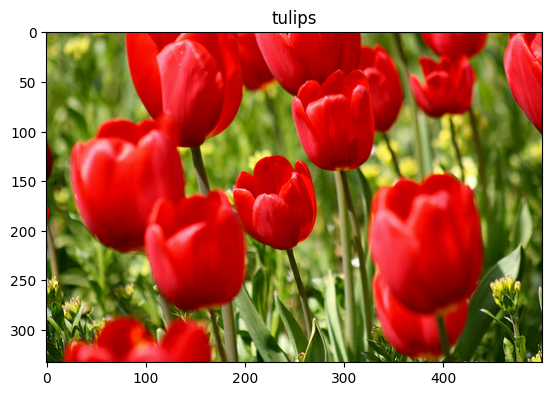

In [6]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

2024-05-01 21:44:49.685586: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(333, 500, 3)


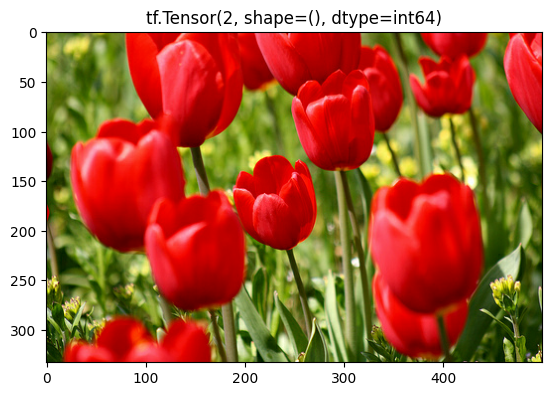

In [7]:
for img, label in train_ds.take(1):
    print(img.shape)
    plt.imshow(img)
    plt.title(label)
    break

In [24]:
image.numpy().max()

255.0

## Use Keras preprocessing layers

### Resizing and rescaling

You can use the Keras preprocessing layers to resize your images to a consistent shape (with [`tf.keras.layers.Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing)), and to rescale pixel values (with [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling)).

In [8]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

**Note:** The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.

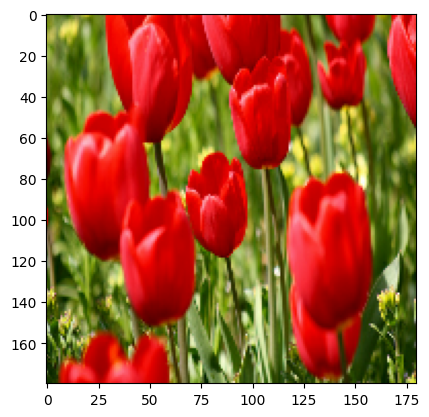

In [9]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [10]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) and [`tf.keras.layers.RandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation).

There are a variety of preprocessing layers you can use for data augmentation including [`tf.keras.layers.RandomContrast`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomContrast), [`tf.keras.layers.RandomCrop`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomCrop), [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom), and others.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [12]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

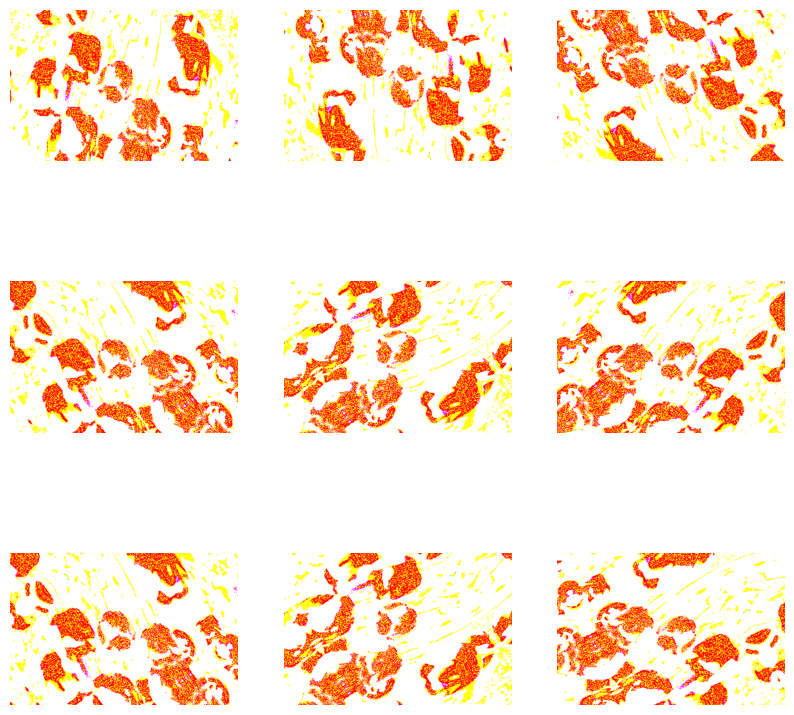

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

#### Option 1: Make the preprocessing layers part of your model
There are two important points to be aware of in this case:

- Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
- When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side

**Note:** Data augmentation is inactive at test time so input images will only be augmented during calls to [`Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) (not [`Model.evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) or [`Model.predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)).

In [14]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

#### Option 2: Apply the preprocessing layers to your dataset

With this approach, you use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to create a dataset that yields batches of augmented images. In this case:

- Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), shown below.
- In this case the preprocessing layers will not be exported with the model when you call [`Model.save`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save). You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

In [15]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. (Learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.)

**Note:** Data augmentation should only be applied to the training set.

In [16]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

In [18]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7920 - loss: 0.5516 - val_accuracy: 0.7330 - val_loss: 0.7328
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7743 - loss: 0.5867 - val_accuracy: 0.7084 - val_loss: 0.8204
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7748 - loss: 0.5712 - val_accuracy: 0.7411 - val_loss: 0.6656
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8129 - loss: 0.4964 - val_accuracy: 0.7112 - val_loss: 0.7757
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7915 - loss: 0.5139 - val_accuracy: 0.6975 - val_loss: 0.7981


In [22]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7235 - loss: 0.7568 
Accuracy 0.7356948256492615


### Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

- First, you will create a [`tf.keras.layers.Lambda`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layer. This is a good way to write concise code.
- Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control.

Both layers will randomly invert the colors in an image, according to some probability.


In [23]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [25]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

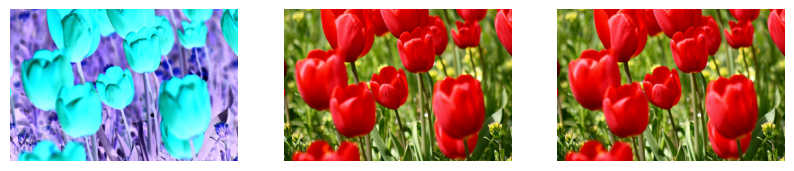

In [27]:
plt.figure(figsize=(10, 10))
for i in range(3):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by subclassing:

In [28]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

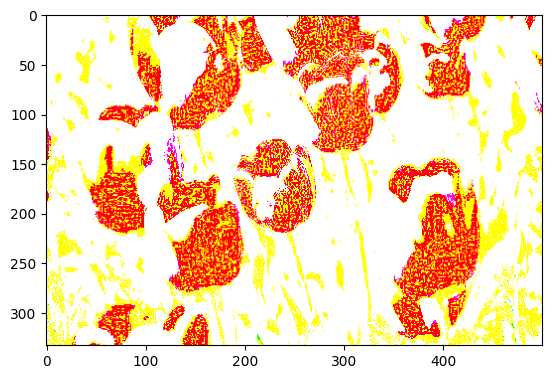

In [29]:
_ = plt.imshow(RandomInvert()(image)[0])

## Using tf.image

The above Keras preprocessing utilities are convenient. But, for finer control, you can write your own data augmentation pipelines or layers using [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image). (You may also want to check out [TensorFlow Addons Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops) and [TensorFlow I/O: Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace).)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh:

In [30]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2024-05-01 22:15:30.496276: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


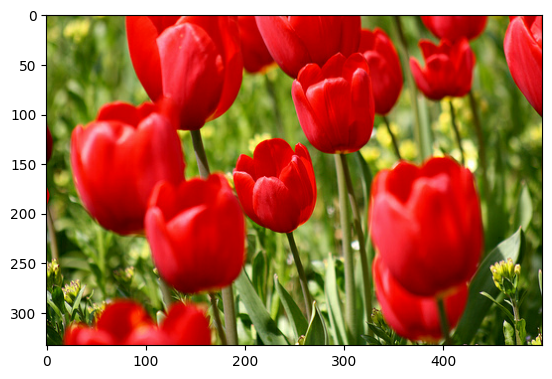

In [37]:
image, label = next(iter(train_ds))
plt.imshow(image)

In [31]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

#### Flip an image

Flip an image either vertically or horizontally with [`tf.image.flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right):

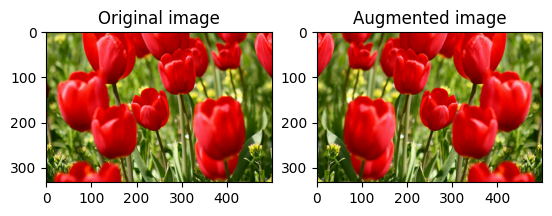

In [38]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale an image

You can grayscale an image with [`tf.image.rgb_to_grayscale`](https://www.tensorflow.org/api_docs/python/tf/image/rgb_to_grayscale):

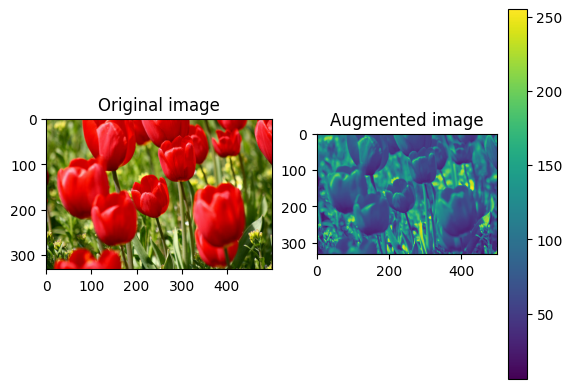

In [39]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### Saturate an image

Saturate an image with [`tf.image.adjust_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/adjust_saturation) by providing a saturation factor:

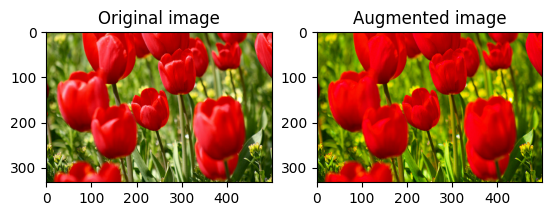

In [40]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Change image brightness

Change the brightness of image with [`tf.image.adjust_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness) by providing a brightness factor:

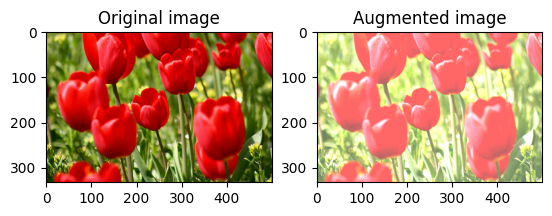

In [41]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Center crop an image

Crop the image from center up to the image part you desire using [`tf.image.central_crop`](https://www.tensorflow.org/api_docs/python/tf/image/central_crop):

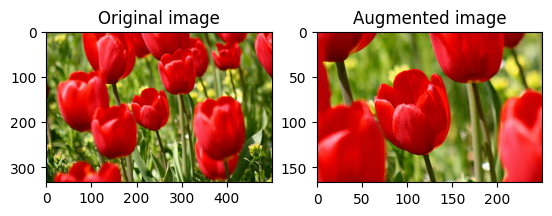

In [42]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### Rotate an image

Rotate an image by 90 degrees with [`tf.image.rot90`](https://www.tensorflow.org/api_docs/python/tf/image/rot90):

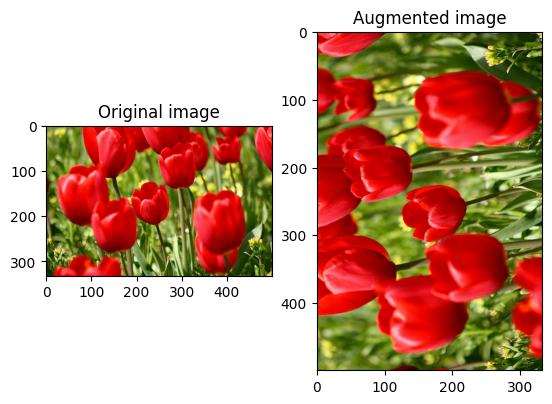

In [43]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Random transformations

pplying random transformations to the images can further help generalize and expand the dataset. The current [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) API provides eight such random image operations (ops):

- [`tf.image.stateless_random_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness)
- [`tf.image.stateless_random_contrast`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_contrast)
- [`tf.image.stateless_random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_crop)
- [`tf.image.stateless_random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_left_right)
- [`tf.image.stateless_random_flip_up_down`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_up_down)
- [`tf.image.stateless_random_hue`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_hue)
- [`tf.image.stateless_random_jpeg_quality`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_jpeg_quality)
- [`tf.image.stateless_random_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_saturation)

These random image ops are purely functional: the output only depends on the input. This makes them simple to use in high performance, deterministic input pipelines. They require a `seed` value be input each step. Given the same `seed`, they return the same results independent of how many times they are called.

**Note:** `seed` is a `Tensor` of shape `(2,)` whose values are any integers.

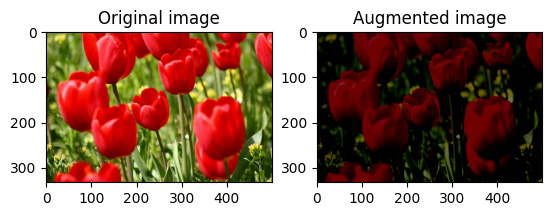

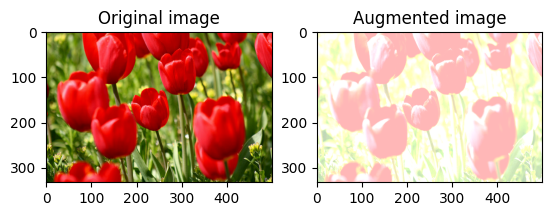

In [44]:
for i in range(2):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

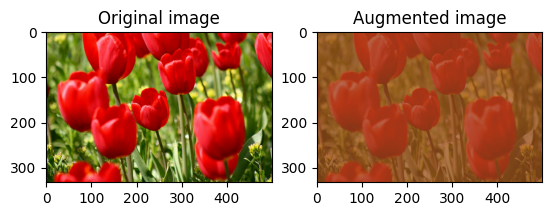

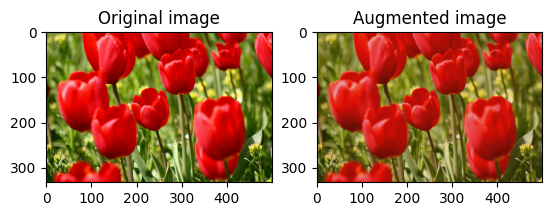

In [45]:
for i in range(2):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

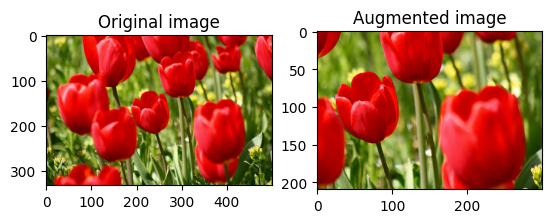

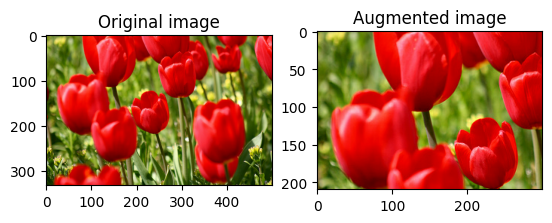

In [47]:
for i in range(2):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

Let's first download the image dataset again in case they are modified in the previous sections.

In [48]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [49]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [50]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### Option 1: Using tf.data.experimental.Counter

Create a [`tf.data.experimental.Counter`](https://www.tensorflow.org/api_docs/python/tf/data/experimental/Counter) object (let's call it `counter`) and [`Dataset.zip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip) the dataset with `(counter, counter)`. This will ensure that each image in the dataset gets associated with a unique value (of shape `(2,)`) based on `counter` which later can get passed into the `augment` function as the `seed` value for random transformations.

In [51]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


In [52]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [53]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [54]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### Option 2: Using tf.random.Generator

- Create a [`tf.random.Generator`](https://www.tensorflow.org/api_docs/python/tf/random/Generator) object with an initial `seed` value. Calling the `make_seeds` function on the same generator object always returns a new, unique `seed` value.
- Define a wrapper function that: 1) calls the `make_seeds` function; and 2) passes the newly generated `seed` value into the `augment` function for random transformations.

**Note:** [`tf.random.Generator`](https://www.tensorflow.org/api_docs/python/tf/random/Generator) objects store RNG state in a [`tf.Variable`](https://www.tensorflow.org/api_docs/python/tf/Variable), which means it can be saved as a [checkpoint](https://www.tensorflow.org/guide/checkpoint) or in a [SavedModel](https://www.tensorflow.org/guide/saved_model). For more details, please refer to [Random number generation](https://www.tensorflow.org/guide/random_numbers).

In [55]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [56]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(1)[:, 0]
  image, label = augment((x, y), seed)
  return image, label

In [58]:
rng.make_seeds(1)[:,0]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([95213998067280893,                 0])>

In [59]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [60]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [61]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)